找到 15 个有效数据文件


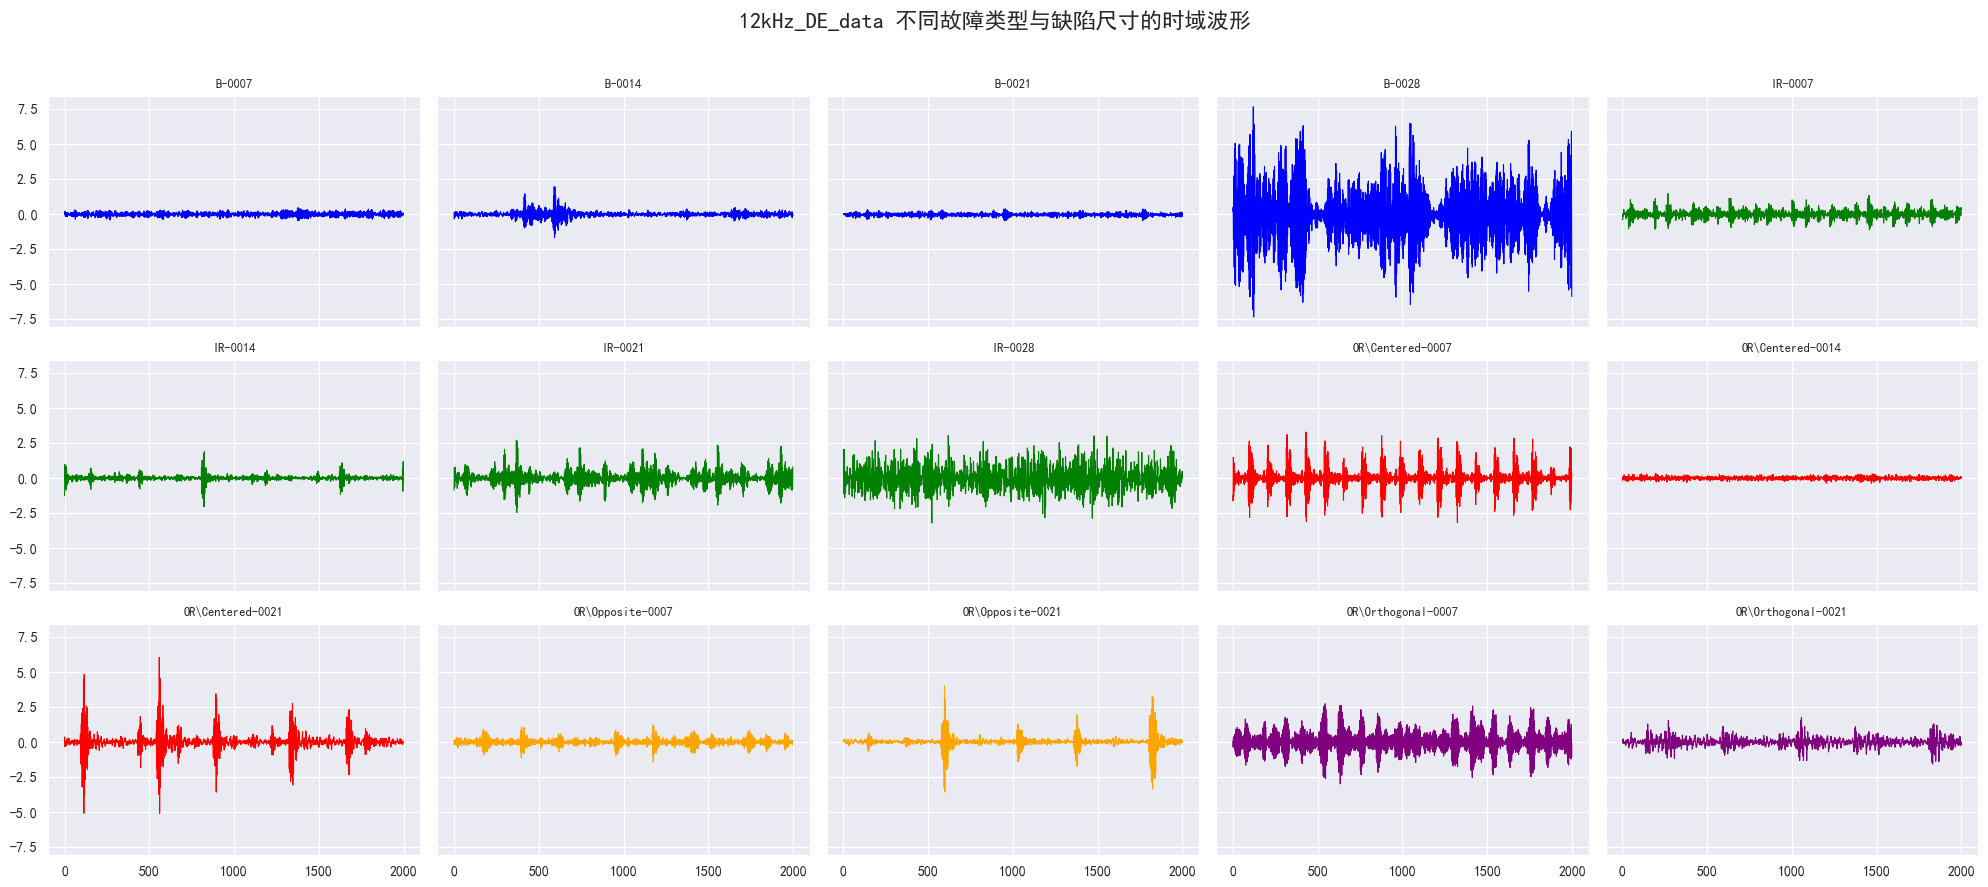

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

root_dir = r"处理后的数据集/12kHz_DE_data"

def get_de_signal(df):
    for col in df.columns:
        if "DE" in col:
            return df[col].dropna().values
    raise KeyError("没有找到 DE 列")

# 定义故障类别
faults = ["B", "IR", os.path.join("OR", "Centered"),
          os.path.join("OR", "Opposite"), os.path.join("OR", "Orthogonal")]
sizes = ["0007", "0014", "0021", "0028"]

# 定义颜色映射
color_map = {
    "B": "blue",
    "IR": "green",
    "Centered": "red",
    "Opposite": "orange",
    "Orthogonal": "purple"
}

# 收集有效数据
file_list = []
for fault in faults:
    for size in sizes:
        folder = os.path.join(root_dir, fault, size)
        if os.path.exists(folder):
            files = [f for f in os.listdir(folder) if f.endswith(".csv")]
            if files:
                file_path = os.path.join(folder, files[0])  # 每个尺寸取一个文件
                file_list.append((fault, size, file_path))

print(f"找到 {len(file_list)} 个有效数据文件")

# 固定 3 行 5 列
rows, cols = 3, 5
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), sharex=True, sharey=True)
axes = axes.ravel()

# 绘制
for idx, (fault, size, file_path) in enumerate(file_list):
    df = pd.read_csv(file_path)
    signal = get_de_signal(df)

    # 取颜色（对 OR 里的子目录特殊处理）
    fault_label = fault.split(os.sep)[-1] if "OR" in fault else fault
    color = color_map.get(fault_label, "black")

    axes[idx].plot(signal[:2000], linewidth=0.8, color=color)
    axes[idx].set_title(f"{fault}-{size}", fontsize=9)

# 隐藏多余子图（如果不足 15 个）
for k in range(len(file_list), rows*cols):
    axes[k].set_visible(False)

plt.suptitle("12kHz_DE_data 不同故障类型与缺陷尺寸的时域波形", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [6]:
import numpy as np
import pandas as pd
import os
from scipy.signal import butter, filtfilt
import pywt

# ====== 预处理函数 ======
def bandpass_filter(signal, fs, lowcut=500, highcut=3000, order=4):
    """巴特沃斯带通滤波"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet="db8", level=3):
    """小波阈值去噪"""
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs = [pywt.threshold(c, value=uthresh, mode="soft") for c in coeffs]
    return pywt.waverec(coeffs, wavelet)

def preprocess_signal(signal, fs, method="bandpass"):
    """统一预处理接口"""
    if method == "bandpass":
        return bandpass_filter(signal, fs)
    elif method == "wavelet":
        return wavelet_denoise(signal)
    else:
        return signal  # 不处理

找到 161 个文件


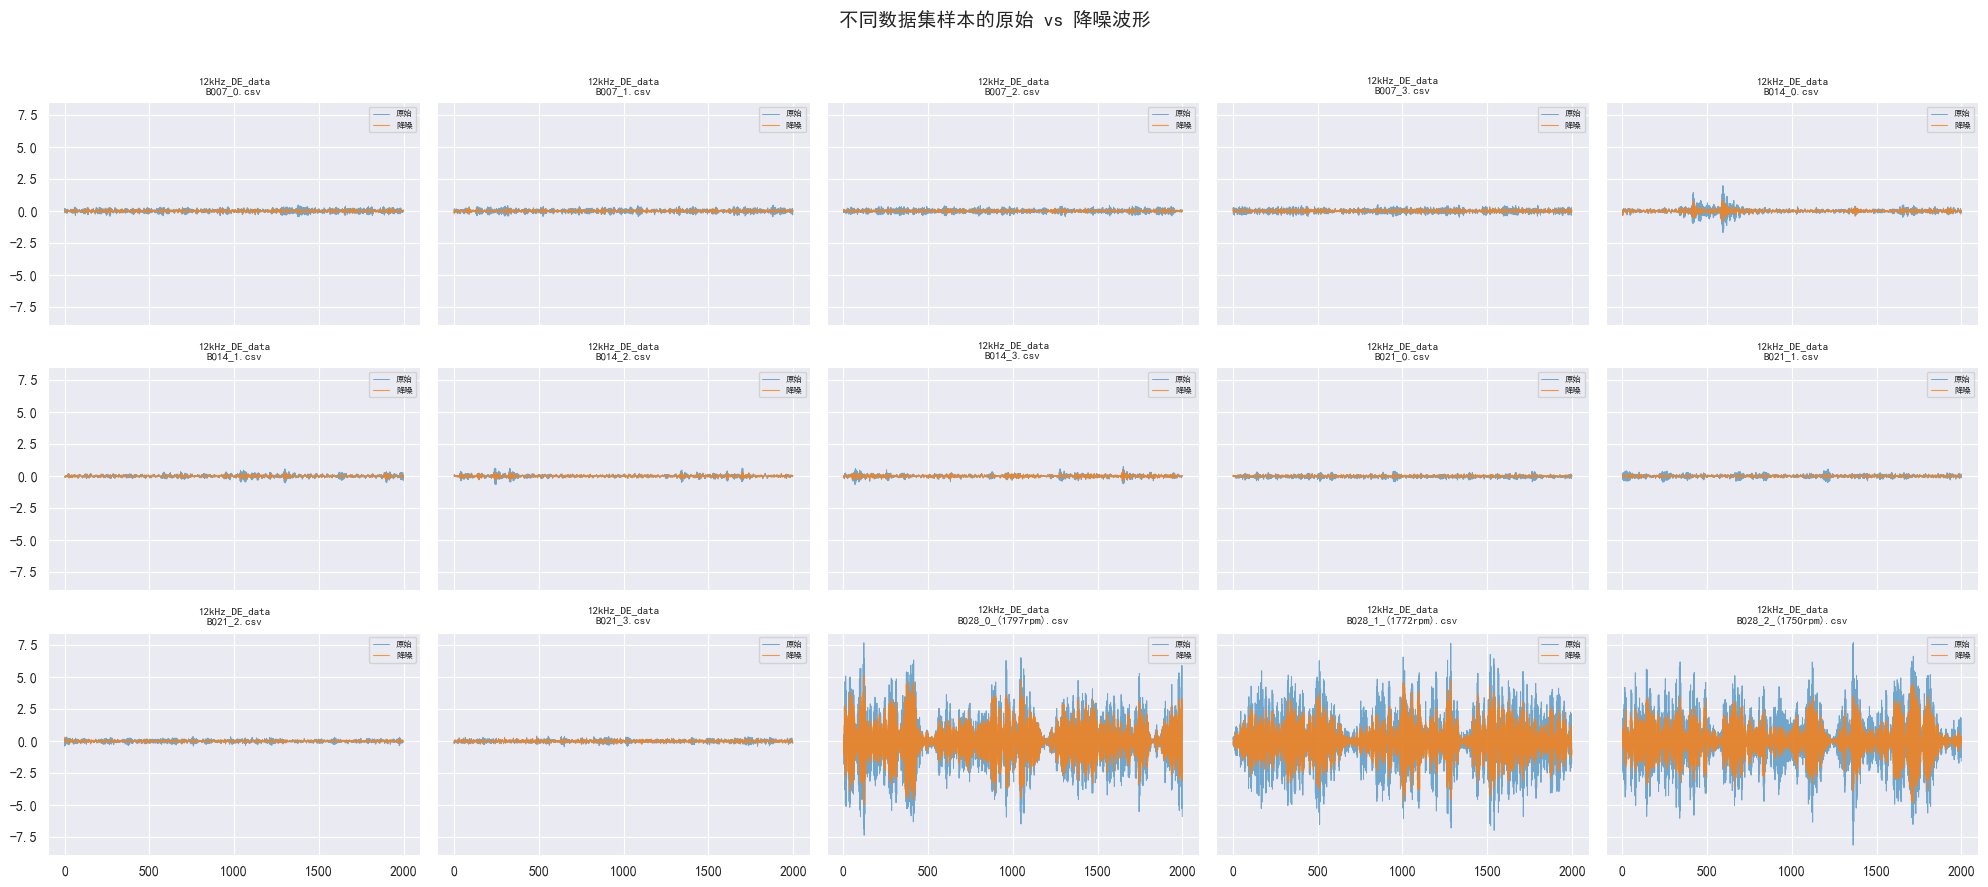

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pywt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文
plt.rcParams['axes.unicode_minus'] = False

# =================== 降噪函数 ===================
def bandpass_filter(signal, fs, lowcut=500, highcut=3000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

def wavelet_denoise(signal, wavelet="db8", level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs = [pywt.threshold(c, value=uthresh, mode="soft") for c in coeffs]
    return pywt.waverec(coeffs, wavelet)

def preprocess_signal(signal, fs, method="bandpass"):
    if method == "bandpass":
        return bandpass_filter(signal, fs)
    elif method == "wavelet":
        return wavelet_denoise(signal)
    else:
        return signal

# =================== 批量读取 ===================
root_dirs = {
    "12kHz_DE_data": 12000,
    "12kHz_FE_data": 12000,
    "48kHz_DE_data": 48000,
    "48kHz_Normal_data": 48000
}

file_list = []
for dataset, fs in root_dirs.items():
    root_path = os.path.join(r"处理后的数据集", dataset)
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.endswith(".csv") and "summary" not in file:
                file_list.append((dataset, fs, os.path.join(root, file)))

print(f"找到 {len(file_list)} 个文件")

# =================== 展示多张子图 ===================
rows, cols = 3, 5   # 比如展示 15 张
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), sharex=True, sharey=True)
axes = axes.ravel()

for idx, (dataset, fs, file_path) in enumerate(file_list[:rows*cols]):  # 只展示前15个
    try:
        df = pd.read_csv(file_path)
        signal = None
        for col in df.columns:
            if "DE" in col or "FE" in col:
                signal = df[col].dropna().values
                break
        if signal is None:
            continue

        # 预处理（降噪）
        signal_filtered = preprocess_signal(signal, fs, method="bandpass")

        # 绘制前2000点
        axes[idx].plot(signal[:2000], alpha=0.6, label="原始", linewidth=0.7)
        axes[idx].plot(signal_filtered[:2000], alpha=0.8, label="降噪", linewidth=0.8)
        axes[idx].set_title(f"{dataset}\n{os.path.basename(file_path)}", fontsize=8)
        axes[idx].legend(fontsize=6, loc="upper right")
    except Exception as e:
        axes[idx].text(0.5, 0.5, "读取失败", ha="center", va="center")
        print(f"❌ 读取失败 {file_path}: {e}")

# 去掉多余子图
for k in range(len(file_list), rows*cols):
    axes[k].set_visible(False)

plt.suptitle("不同数据集样本的原始 vs 降噪波形", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [8]:
import os
import pandas as pd
import numpy as np

# 根目录
root_dir = r"处理后的数据集/12kHz_DE_data"

# 定义一个函数：提取时域特征
def extract_time_features(signal):
    N = len(signal)
    mean = np.mean(signal)
    std = np.std(signal)
    rms = np.sqrt(np.mean(signal**2))
    peak = np.max(np.abs(signal))
    skewness = pd.Series(signal).skew()
    kurtosis = pd.Series(signal).kurt()
    cf = peak / (rms + 1e-8)
    if_ = peak / (np.mean(np.abs(signal)) + 1e-8)
    mf = peak / ((np.mean(np.sqrt(np.abs(signal)))**2) + 1e-8)

    return {
        "均值": mean,
        "标准差": std,
        "均方根": rms,
        "峰值": peak,
        "偏度": skewness,
        "峭度": kurtosis,
        "峰值因子": cf,
        "脉冲因子": if_,
        "裕度因子": mf
    }

# 自动找到 DE 列
def get_de_signal(df):
    for col in df.columns:
        if "DE" in col:  # 找到包含“DE”的列
            return df[col].dropna().values
    raise KeyError("没有找到 DE 列")

# 遍历目录
results = []
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            try:
                df = pd.read_csv(file_path)
                signal = get_de_signal(df)
                features = extract_time_features(signal)
                features["FileName"] = file
                features["Folder"] = os.path.basename(root)
                results.append(features)
            except Exception as e:
                print(f"❌ 文件 {file_path} 处理失败: {e}")

# 汇总为 DataFrame
features_df = pd.DataFrame(results)

# 保存结果
output_path = os.path.join(root_dir, "time_features_summary.csv")
features_df.to_csv(output_path, index=False, encoding="utf-8-sig")

print("✅ 时域特征提取完成，结果已保存到:", output_path)
print(features_df.head())

✅ 时域特征提取完成，结果已保存到: 处理后的数据集/12kHz_DE_data\time_features_summary.csv
         均值       标准差       均方根        峰值        偏度         峭度       峰值因子  \
0  0.000144  0.137790  0.137790  0.619627 -0.006781  -0.041105   4.496886   
1 -0.000073  0.138850  0.138850  0.663541  0.007698  -0.028893   4.778828   
2 -0.000055  0.147506  0.147506  0.600019  0.033861  -0.150594   4.067760   
3 -0.000042  0.154108  0.154108  0.724762  0.018634  -0.098679   4.702963   
4 -0.000057  0.147515  0.147515  2.273465  0.274315  17.807148  15.411731   

        脉冲因子       裕度因子    FileName Folder  
0   5.628231   6.642000  B007_0.csv   0007  
1   5.974089   7.039744  B007_1.csv   0007  
2   5.065223   5.960643  B007_2.csv   0007  
3   5.865919   6.910110  B007_3.csv   0007  
4  23.562305  29.842544  B014_0.csv   0014  


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import acf

def plot_time_domain_visualizations(signal, title="信号时域可视化"):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.ravel()

    # 1. 概率密度
    sns.kdeplot(signal, fill=True, color="blue", ax=axes[0])
    axes[0].set_title("概率密度分布")

    # 2. 自相关函数
    acf_vals = acf(signal, nlags=200)
    axes[1].plot(acf_vals)
    axes[1].set_title("自相关函数")

    # 3. 累积分布
    sorted_vals = np.sort(signal)
    cdf = np.arange(len(signal)) / len(signal)
    axes[2].plot(sorted_vals, cdf)
    axes[2].set_title("累积分布函数")

    # 4. 箱线图
    axes[3].boxplot(signal, vert=True, patch_artist=True)
    axes[3].set_title("箱线图")

    # 5. 滑动 RMS
    window = 200
    rms_vals = np.array([np.sqrt(np.mean(signal[i:i+window]**2))
                         for i in range(len(signal)-window)])
    axes[4].plot(rms_vals)
    axes[4].set_title("滑动 RMS 能量")

    # 6. 原始时域波形
    axes[5].plot(signal[:2000])
    axes[5].set_title("时域波形")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

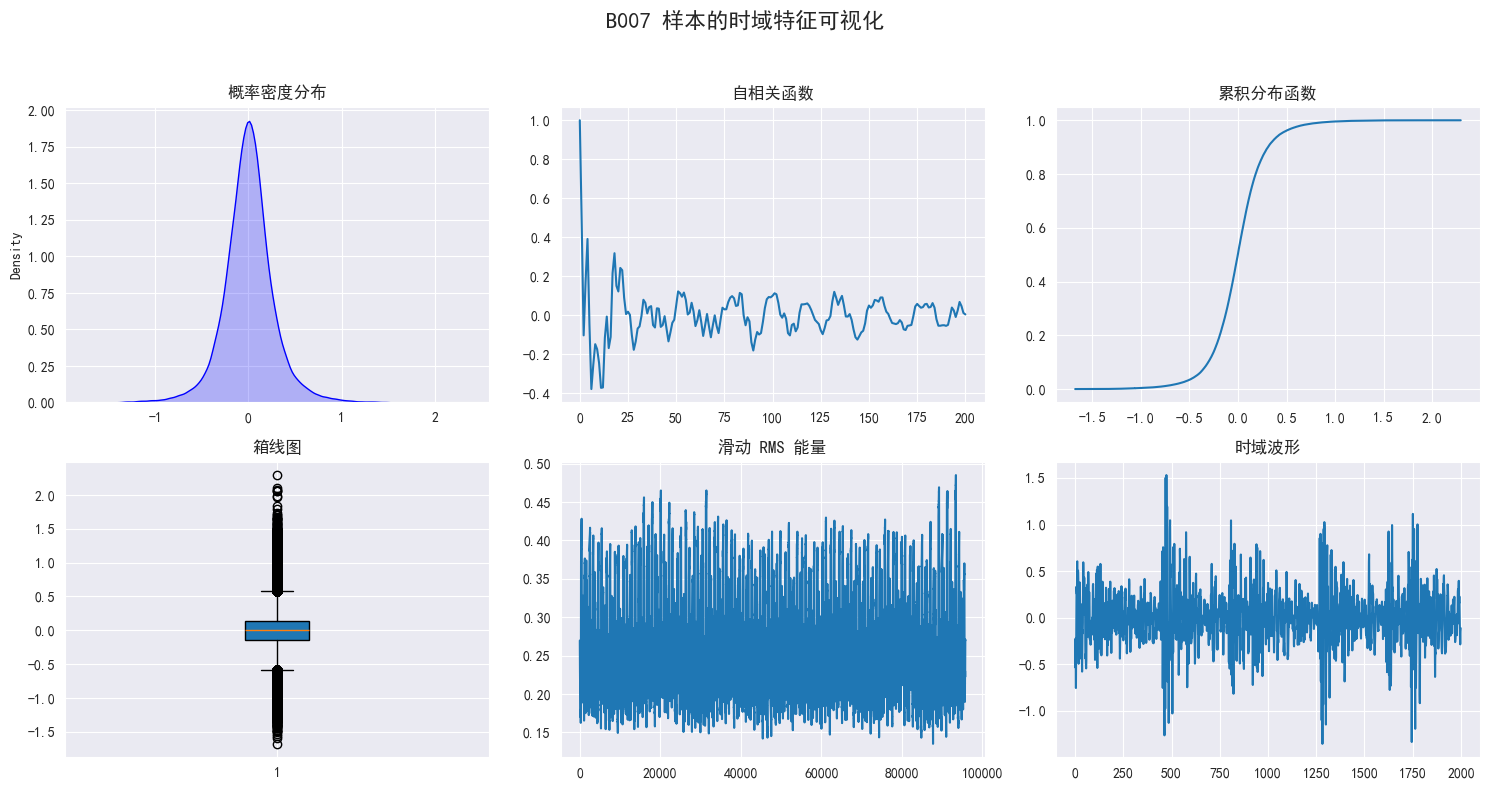

In [11]:
plot_time_domain_visualizations(signal, title="B007 样本的时域特征可视化")

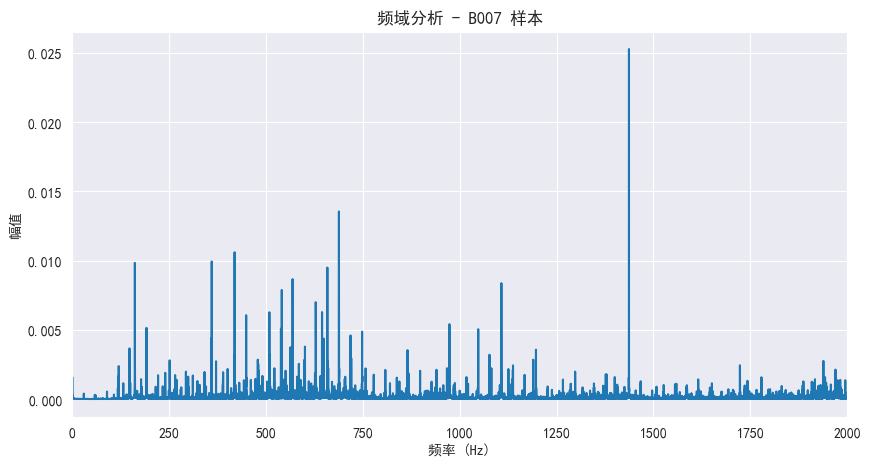

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取一个样本信号
file_path = r"处理后的数据集/12kHz_DE_data\B\0007\B007_0.csv"
df = pd.read_csv(file_path)

# 自动找到 DE 列
col = [c for c in df.columns if "DE" in c][0]
signal = df[col].values
N = len(signal)

# 采样频率（CWRU 数据集是 12 kHz）
fs = 12000  
t = np.arange(N) / fs

# === FFT ===
fft_vals = np.fft.fft(signal)
fft_vals = np.abs(fft_vals[:N//2]) * 2 / N   # 取前一半，幅值归一化
freqs = np.fft.fftfreq(N, 1/fs)[:N//2]

# 绘制频谱
plt.figure(figsize=(10,5))
plt.plot(freqs, fft_vals)
plt.title("频域分析 - B007 样本")
plt.xlabel("频率 (Hz)")
plt.ylabel("幅值")
plt.xlim(0, 2000)  # 只画 0-2000 Hz（常用范围）
plt.grid(True)
plt.show()

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

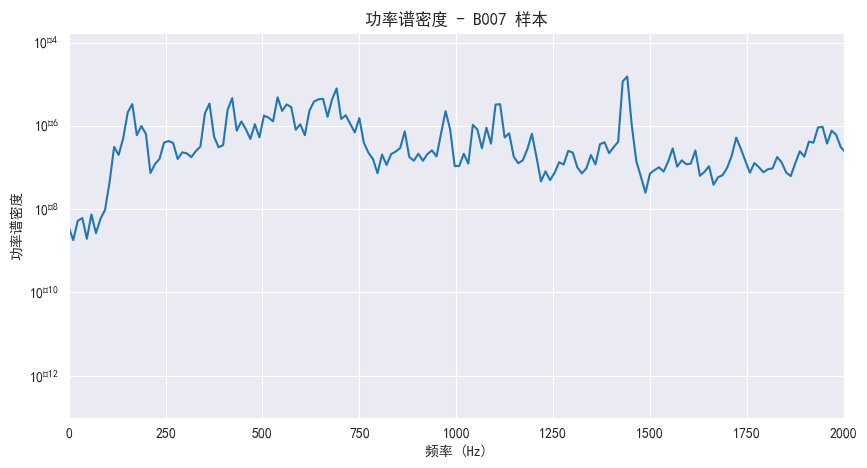

In [13]:
from scipy.signal import welch

f, Pxx = welch(signal, fs=fs, nperseg=1024)

plt.figure(figsize=(10,5))
plt.semilogy(f, Pxx)
plt.title("功率谱密度 - B007 样本")
plt.xlabel("频率 (Hz)")
plt.ylabel("功率谱密度")
plt.xlim(0, 2000)
plt.grid(True)
plt.show()

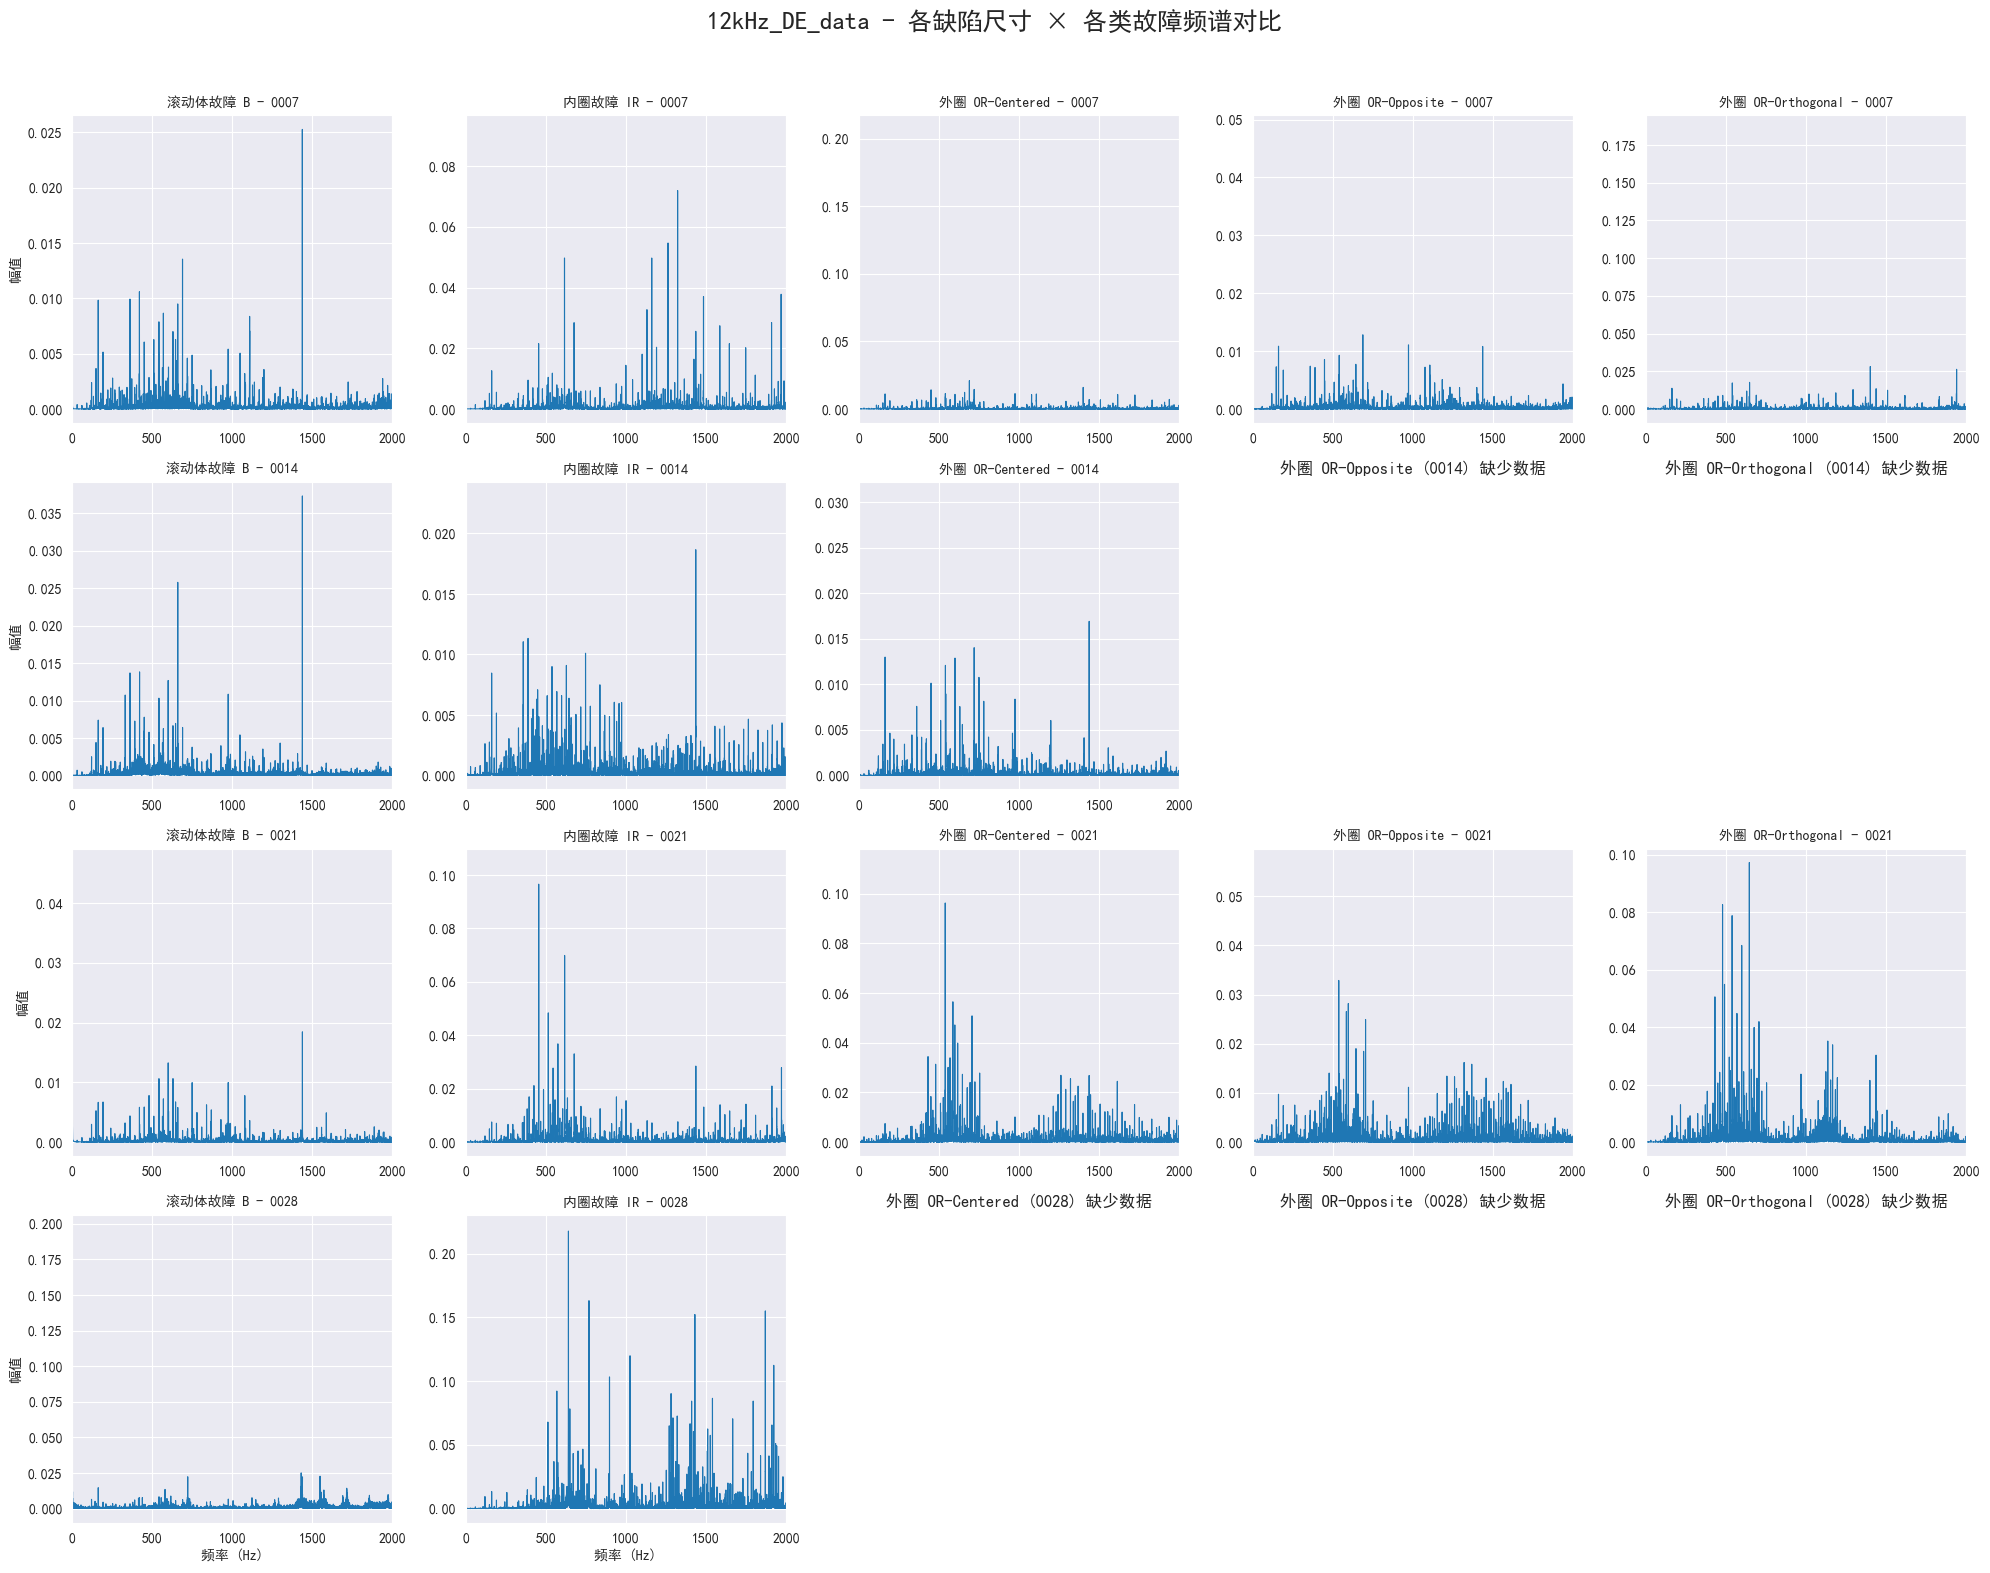

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

root_dir = r"处理后的数据集/12kHz_DE_data"

# 缺陷尺寸和类别
defect_sizes = ["0007", "0014", "0021", "0028"]
fault_types = {
    "滚动体故障 B": ["B"],
    "内圈故障 IR": ["IR"],
    "外圈 OR-Centered": ["OR", "Centered"],
    "外圈 OR-Opposite": ["OR", "Opposite"],
    "外圈 OR-Orthogonal": ["OR", "Orthogonal"]
}

fs = 12000  # 采样频率

def get_de_signal(df):
    for col in df.columns:
        if "DE" in col:
            return df[col].dropna().values
    raise KeyError("没有找到 DE 列")

def compute_fft(signal, fs):
    N = len(signal)
    fft_vals = np.fft.fft(signal)
    fft_vals = np.abs(fft_vals[:N//2]) * 2 / N
    freqs = np.fft.fftfreq(N, 1/fs)[:N//2]
    return freqs, fft_vals

# ==== 绘制网格：行=缺陷尺寸，列=故障类型 ====
fig, axes = plt.subplots(len(defect_sizes), len(fault_types), figsize=(20, 16))
axes = np.array(axes)

for i, size in enumerate(defect_sizes):
    for j, (title, parts) in enumerate(fault_types.items()):
        ax = axes[i, j]

        # 拼接路径
        if len(parts) == 1:  # B, IR
            folder = os.path.join(root_dir, parts[0], size)
        else:  # OR 类
            folder = os.path.join(root_dir, parts[0], parts[1], size)

        if not os.path.exists(folder):
            ax.set_title(f"{title} ({size}) 缺少数据")
            ax.axis("off")
            continue

        files = [f for f in os.listdir(folder) if f.endswith(".csv")]
        if not files:
            ax.set_title(f"{title} ({size}) 没有CSV文件")
            ax.axis("off")
            continue

        # 取第一个CSV文件
        file_path = os.path.join(folder, files[0])
        df = pd.read_csv(file_path)
        signal = get_de_signal(df)

        freqs, fft_vals = compute_fft(signal, fs)

        ax.plot(freqs, fft_vals, lw=0.8)
        ax.set_xlim(0, 2000)
        ax.set_title(f"{title} - {size}", fontsize=10)
        if i == len(defect_sizes) - 1:
            ax.set_xlabel("频率 (Hz)")
        if j == 0:
            ax.set_ylabel("幅值")

plt.suptitle("12kHz_DE_data - 各缺陷尺寸 × 各类故障频谱对比", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

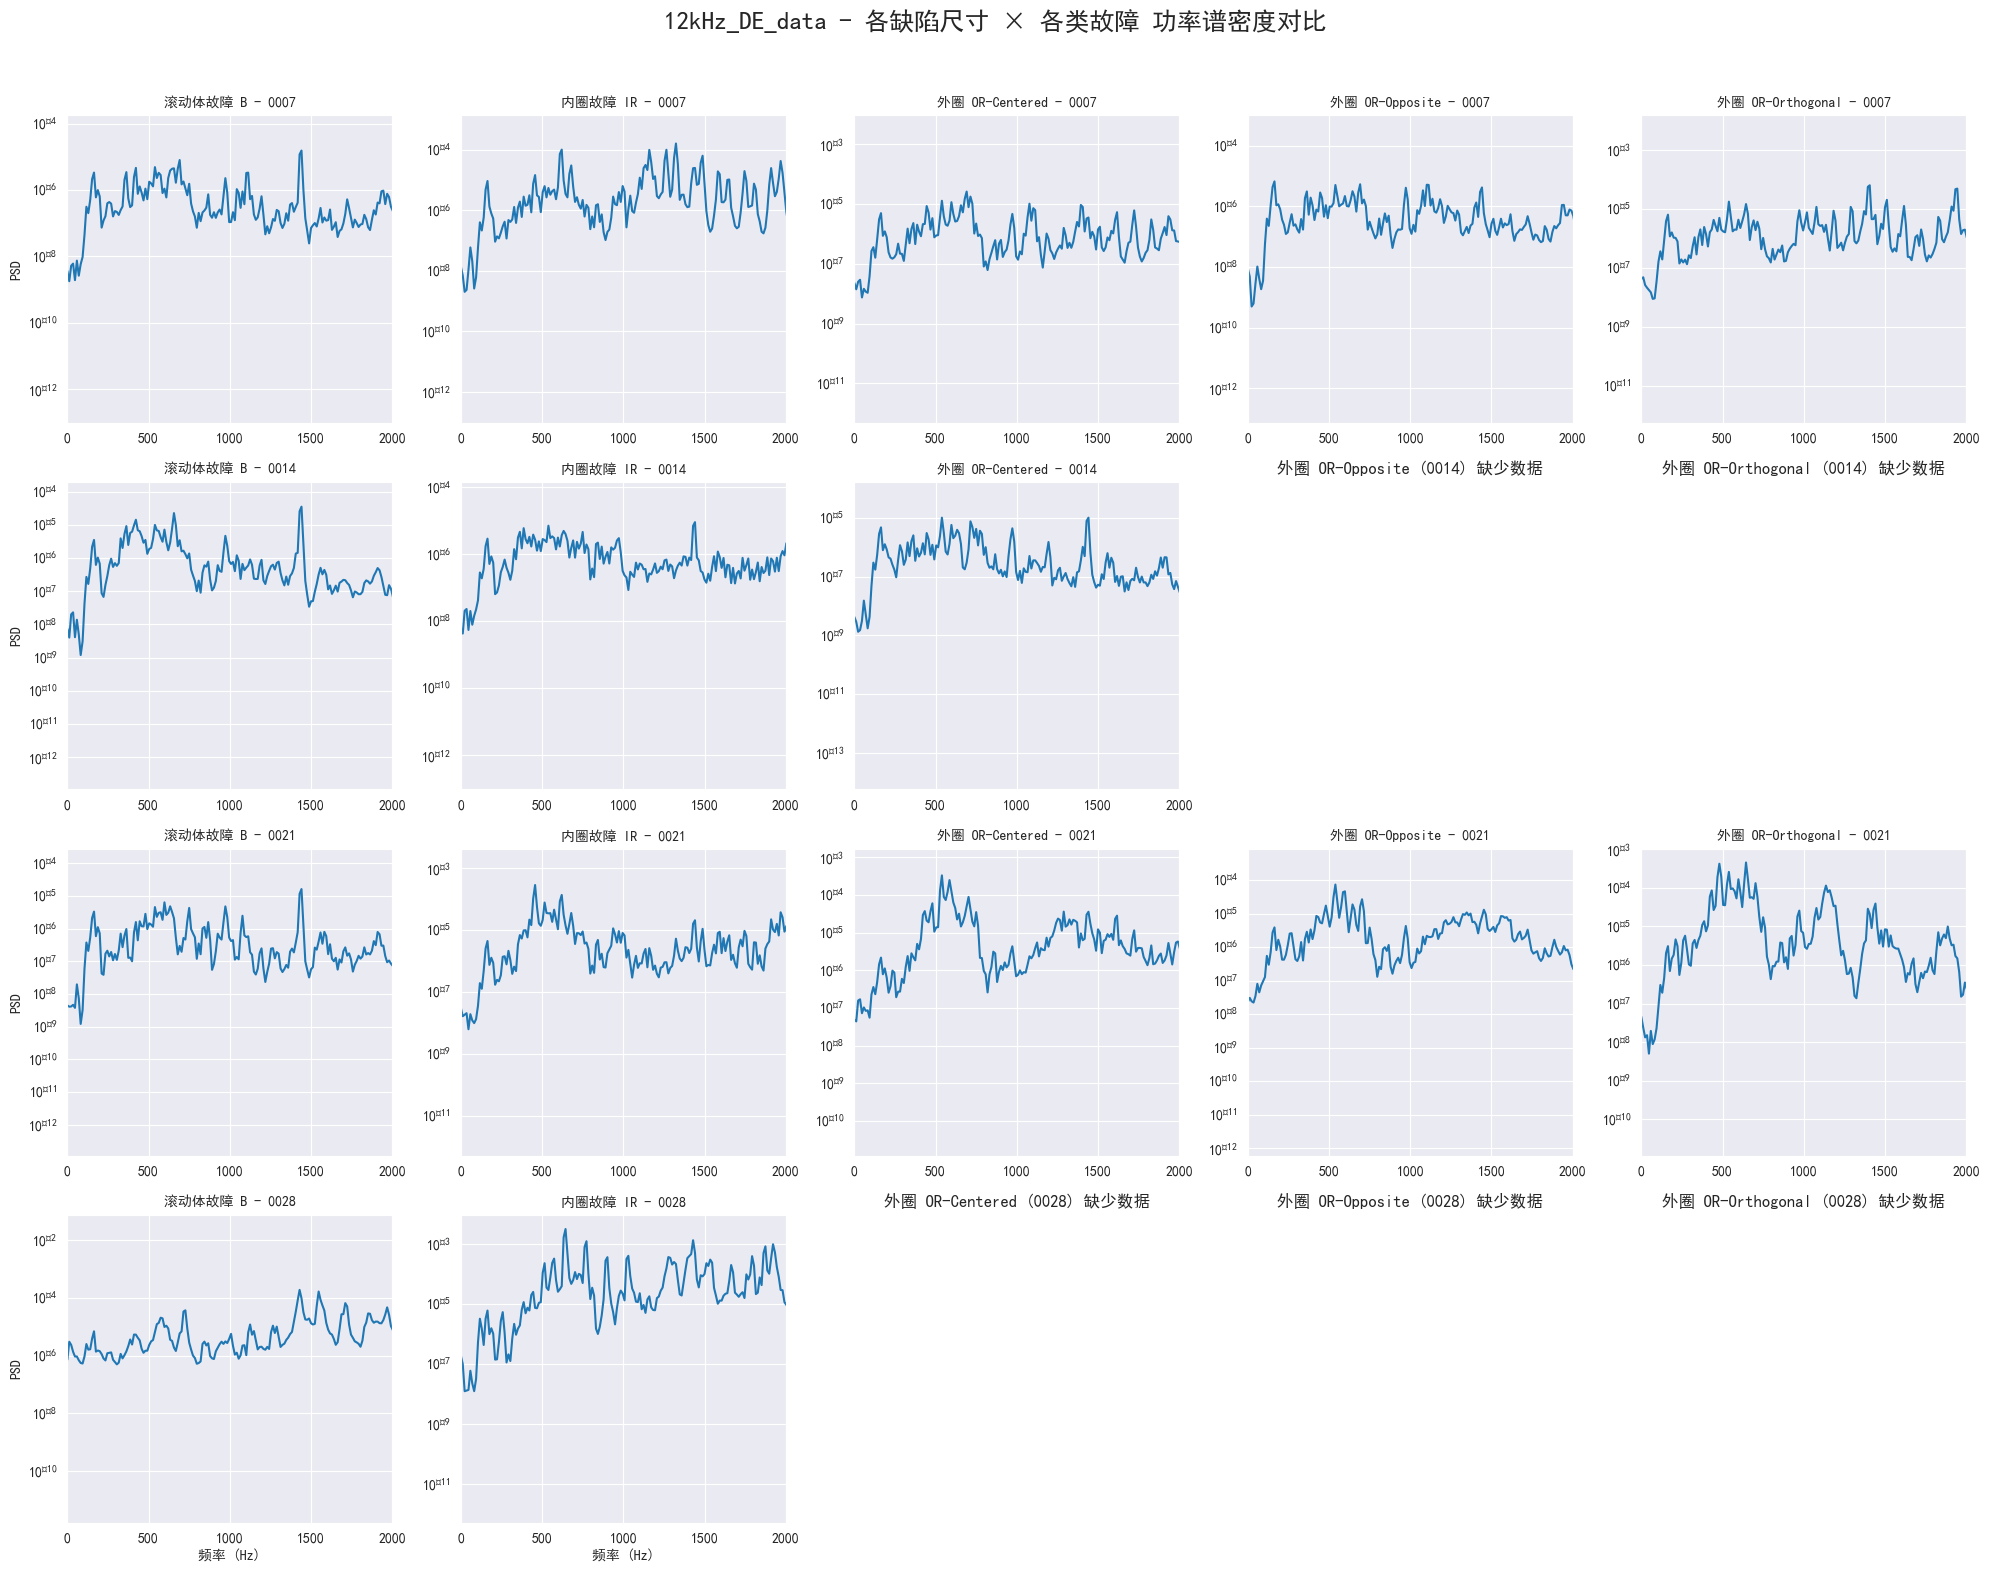

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# 设置中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

root_dir = r"处理后的数据集/12kHz_DE_data"

# 缺陷尺寸和类别
defect_sizes = ["0007", "0014", "0021", "0028"]
fault_types = {
    "滚动体故障 B": ["B"],
    "内圈故障 IR": ["IR"],
    "外圈 OR-Centered": ["OR", "Centered"],
    "外圈 OR-Opposite": ["OR", "Opposite"],
    "外圈 OR-Orthogonal": ["OR", "Orthogonal"]
}

fs = 12000  # 采样频率

def get_de_signal(df):
    for col in df.columns:
        if "DE" in col:
            return df[col].dropna().values
    raise KeyError("没有找到 DE 列")

# ==== 绘制功率谱密度 (Welch) ====
fig, axes = plt.subplots(len(defect_sizes), len(fault_types), figsize=(20, 16))
axes = np.array(axes)

for i, size in enumerate(defect_sizes):
    for j, (title, parts) in enumerate(fault_types.items()):
        ax = axes[i, j]

        # 拼路径
        if len(parts) == 1:
            folder = os.path.join(root_dir, parts[0], size)
        else:
            folder = os.path.join(root_dir, parts[0], parts[1], size)

        if not os.path.exists(folder):
            ax.set_title(f"{title} ({size}) 缺少数据")
            ax.axis("off")
            continue

        files = [f for f in os.listdir(folder) if f.endswith(".csv")]
        if not files:
            ax.set_title(f"{title} ({size}) 没有CSV")
            ax.axis("off")
            continue

        file_path = os.path.join(folder, files[0])
        df = pd.read_csv(file_path)
        signal = get_de_signal(df)

        # Welch PSD
        f, Pxx = welch(signal, fs=fs, nperseg=1024)

        ax.semilogy(f, Pxx)
        ax.set_xlim(0, 2000)
        ax.set_title(f"{title} - {size}", fontsize=10)

        if i == len(defect_sizes) - 1:
            ax.set_xlabel("频率 (Hz)")
        if j == 0:
            ax.set_ylabel("PSD")

plt.suptitle("12kHz_DE_data - 各缺陷尺寸 × 各类故障 功率谱密度对比", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

找到 15 个有效样本


C:\Users\NSwor\AppData\Local\Temp\ipykernel_27492\3229638386.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.92,0.96])


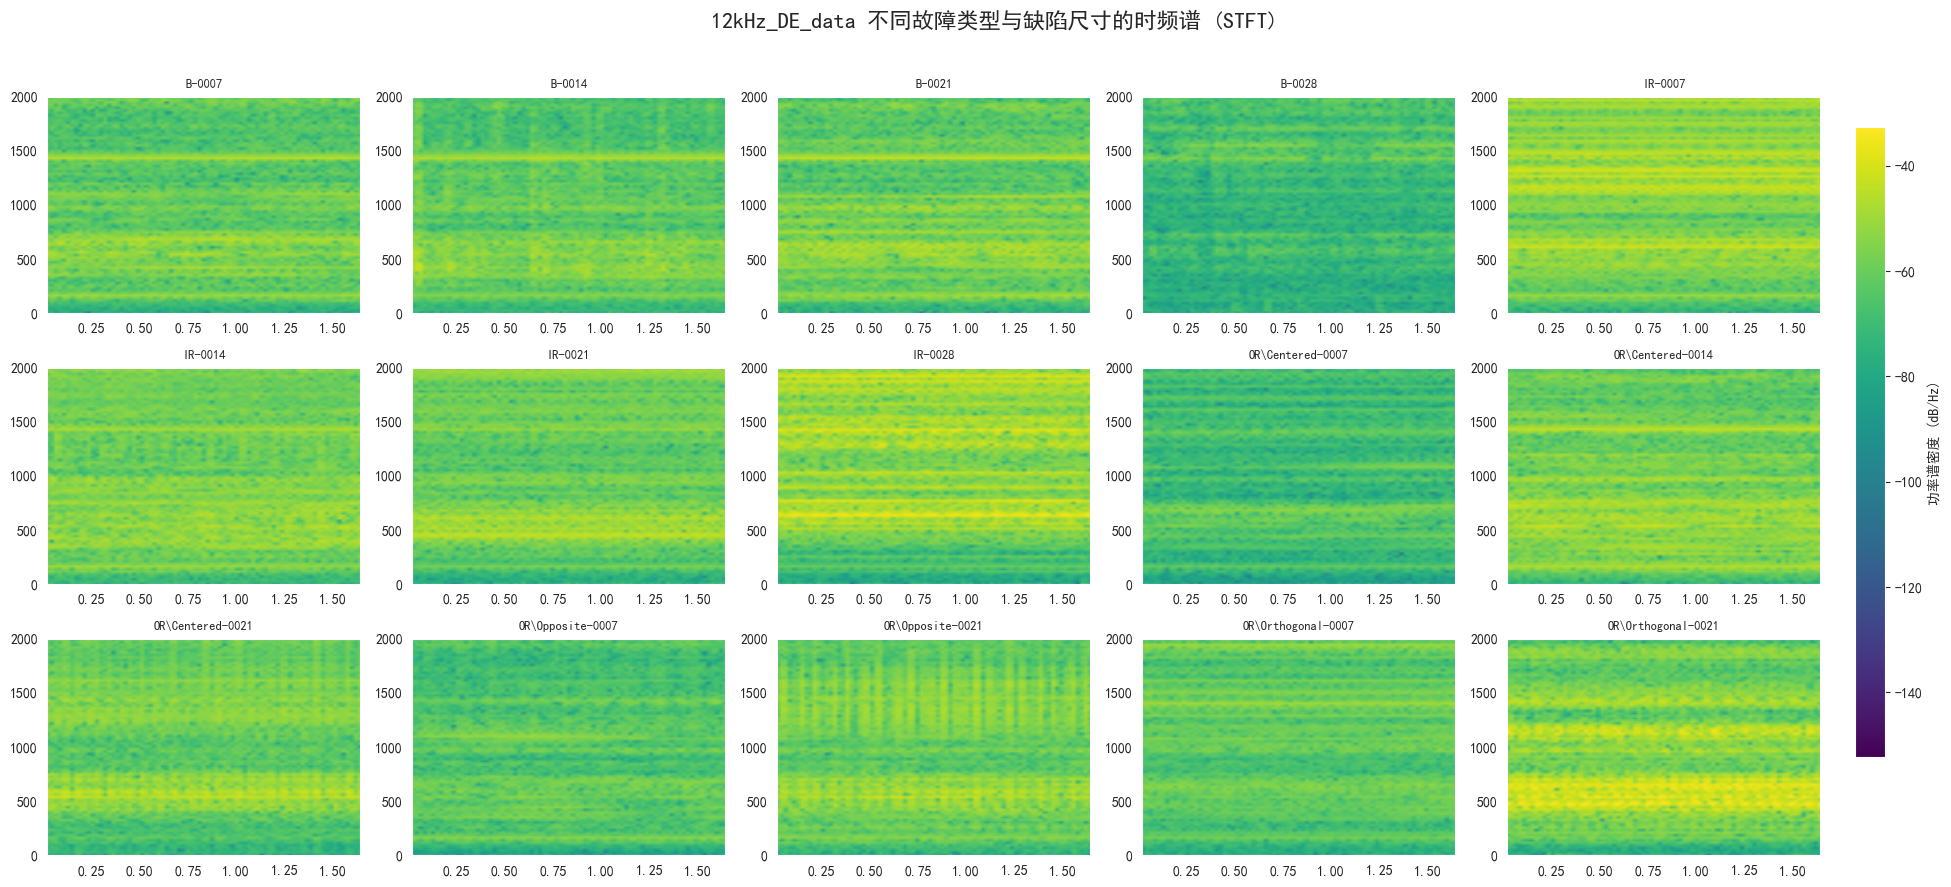

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

root_dir = r"处理后的数据集/12kHz_DE_data"

def get_de_signal(df):
    for col in df.columns:
        if "DE" in col:
            return df[col].dropna().values
    raise KeyError("没有找到 DE 列")

# 定义故障类型和缺陷尺寸
faults = ["B", "IR", os.path.join("OR", "Centered"),
          os.path.join("OR", "Opposite"), os.path.join("OR", "Orthogonal")]
sizes = ["0007", "0014", "0021", "0028"]

# 收集数据
file_list = []
for fault in faults:
    for size in sizes:
        folder = os.path.join(root_dir, fault, size)
        if os.path.exists(folder):
            files = [f for f in os.listdir(folder) if f.endswith(".csv")]
            if files:
                file_path = os.path.join(folder, files[0])
                file_list.append((fault, size, file_path))

print(f"找到 {len(file_list)} 个有效样本")

# 固定 3×5 布局
rows, cols = 3, 5
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), sharex=False, sharey=False)
axes = axes.ravel()

fs = 12000  # CWRU 采样频率

# 绘制 STFT
for idx, (fault, size, file_path) in enumerate(file_list):
    df = pd.read_csv(file_path)
    signal = get_de_signal(df)

    f, t, Sxx = spectrogram(signal[:20000], fs=fs, nperseg=512, noverlap=256)

    im = axes[idx].pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud', cmap="viridis")
    axes[idx].set_title(f"{fault}-{size}", fontsize=9)
    axes[idx].set_ylim(0, 2000)  # 只看 0-2000Hz 范围

# 删除多余子图
for k in range(len(file_list), rows*cols):
    axes[k].set_visible(False)

# 统一加一个 colorbar
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax, label="功率谱密度 (dB/Hz)")

plt.suptitle("12kHz_DE_data 不同故障类型与缺陷尺寸的时频谱 (STFT)", fontsize=16)
plt.tight_layout(rect=[0,0,0.92,0.96])
plt.show()

In [17]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from scipy.signal import welch

# 提取时域特征
def time_domain_features(signal):
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    skew_val = skew(signal)
    kurt_val = kurtosis(signal)
    peak = np.max(np.abs(signal))
    rms = np.sqrt(np.mean(signal**2))
    crest_factor = peak / rms
    impulse_factor = peak / np.mean(np.abs(signal))
    shape_factor = rms / np.mean(np.abs(signal))
    
    return {
        "时域_均值": mean_val,
        "时域_标准差": std_val,
        "时域_偏度": skew_val,
        "时域_峭度": kurt_val,
        "时域_峰值": peak,
        "时域_RMS": rms,
        "时域_峰值因子": crest_factor,
        "时域_脉冲因子": impulse_factor,
        "时域_波形因子": shape_factor
    }

# 提取频域特征
def freq_domain_features(signal, fs=12000):
    N = len(signal)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    spectrum = np.abs(fft(signal))[:len(freqs)]
    spectrum = spectrum / np.sum(spectrum)  # 归一化
    
    mean_freq = np.sum(freqs * spectrum)
    freq_var = np.sum(((freqs - mean_freq)**2) * spectrum)
    freq_centroid = np.sum(freqs * spectrum) / np.sum(spectrum)
    
    # Welch 功率谱
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    main_freq = f[np.argmax(Pxx)]
    
    return {
        "频域_均值频率": mean_freq,
        "频域_频率方差": freq_var,
        "频域_频率重心": freq_centroid,
        "频域_主频": main_freq
    }

# 时频域特征 (STFT 能量熵)
from scipy.signal import spectrogram
def time_freq_features(signal, fs=12000):
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256, noverlap=128)
    Sxx_norm = Sxx / np.sum(Sxx)
    Sxx_norm = Sxx_norm[Sxx_norm > 0]
    entropy = -np.sum(Sxx_norm * np.log(Sxx_norm))
    
    return {
        "时频域_能量熵": entropy
    }

# === 综合特征提取函数 ===
def extract_features(signal, fs=12000):
    features = {}
    features.update(time_domain_features(signal))
    features.update(freq_domain_features(signal, fs))
    features.update(time_freq_features(signal, fs))
    return features

# ===== 示例 =====
import pandas as pd
import os

root_dir = r"处理后的数据集/12kHz_DE_data\B\0007"
file = [f for f in os.listdir(root_dir) if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(root_dir, file))

# 自动找到 DE 列
for col in df.columns:
    if "DE" in col:
        signal = df[col].dropna().values
        break

features = extract_features(signal[:20000], fs=12000)
print(pd.DataFrame([features]))

      时域_均值    时域_标准差     时域_偏度     时域_峭度     时域_峰值   时域_RMS   时域_峰值因子  \
0  0.002275  0.137511 -0.025883 -0.058878  0.570572  0.13753  4.148707   

    时域_脉冲因子   时域_波形因子      频域_均值频率       频域_频率方差      频域_频率重心       频域_主频  \
0  5.192874  1.251685  2778.589368  1.121214e+06  2778.589368  3363.28125   

   时频域_能量熵  
0  7.93389  


In [18]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from scipy.signal import welch, spectrogram

# ====================== 特征函数 ======================
def get_de_signal(df):
    for col in df.columns:
        if "DE" in col:   # Drive End
            return df[col].dropna().values
        if "FE" in col:   # Fan End
            return df[col].dropna().values
    raise KeyError("没有找到 DE 或 FE 列")

def time_domain_features(signal):
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    skew_val = skew(signal)
    kurt_val = kurtosis(signal)
    peak = np.max(np.abs(signal))
    rms = np.sqrt(np.mean(signal**2))
    crest_factor = peak / rms
    impulse_factor = peak / np.mean(np.abs(signal))
    shape_factor = rms / np.mean(np.abs(signal))
    return {
        "时域_均值": mean_val,
        "时域_标准差": std_val,
        "时域_偏度": skew_val,
        "时域_峭度": kurt_val,
        "时域_峰值": peak,
        "时域_RMS": rms,
        "时域_峰值因子": crest_factor,
        "时域_脉冲因子": impulse_factor,
        "时域_波形因子": shape_factor
    }

def freq_domain_features(signal, fs=12000):
    N = len(signal)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    spectrum = np.abs(fft(signal))[:len(freqs)]
    spectrum = spectrum / np.sum(spectrum)
    mean_freq = np.sum(freqs * spectrum)
    freq_var = np.sum(((freqs - mean_freq)**2) * spectrum)
    freq_centroid = np.sum(freqs * spectrum) / np.sum(spectrum)
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    main_freq = f[np.argmax(Pxx)]
    return {
        "频域_均值频率": mean_freq,
        "频域_频率方差": freq_var,
        "频域_频率重心": freq_centroid,
        "频域_主频": main_freq
    }

def time_freq_features(signal, fs=12000):
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=256, noverlap=128)
    Sxx_norm = Sxx / np.sum(Sxx)
    Sxx_norm = Sxx_norm[Sxx_norm > 0]
    entropy = -np.sum(Sxx_norm * np.log(Sxx_norm))
    return {"时频域_能量熵": entropy}

def extract_features(signal, fs=12000):
    features = {}
    features.update(time_domain_features(signal))
    features.update(freq_domain_features(signal, fs))
    features.update(time_freq_features(signal, fs))
    return features

# ====================== 批量处理 ======================
root_dirs = {
    "12kHz_DE_data": 12000,
    "12kHz_FE_data": 12000,
    "48kHz_DE_data": 48000,
    "48kHz_Normal_data": 48000
}

all_features = []

for dataset, fs in root_dirs.items():
    root_path = os.path.join(r"处理后的数据集", dataset)
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.endswith(".csv") and "summary" not in file:  # 🚨 过滤掉 summary 文件
                file_path = os.path.join(root, file)
                try:
                    df = pd.read_csv(file_path)
                    signal = get_de_signal(df).astype(float)
                    signal = signal[:20000]  # 统一长度
                    
                    feats = extract_features(signal, fs)
                    feats["数据集"] = dataset
                    feats["文件名"] = file
                    feats["文件夹"] = os.path.basename(root)
                    all_features.append(feats)
                except Exception as e:
                    print(f"❌ 读取失败 {file_path}: {e}")

# ====================== 保存路径 ======================
save_path = r"all_features.csv"
features_df = pd.DataFrame(all_features)
features_df.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"✅ 特征提取完成，保存为 {save_path}")

✅ 特征提取完成，保存为 all_features.csv


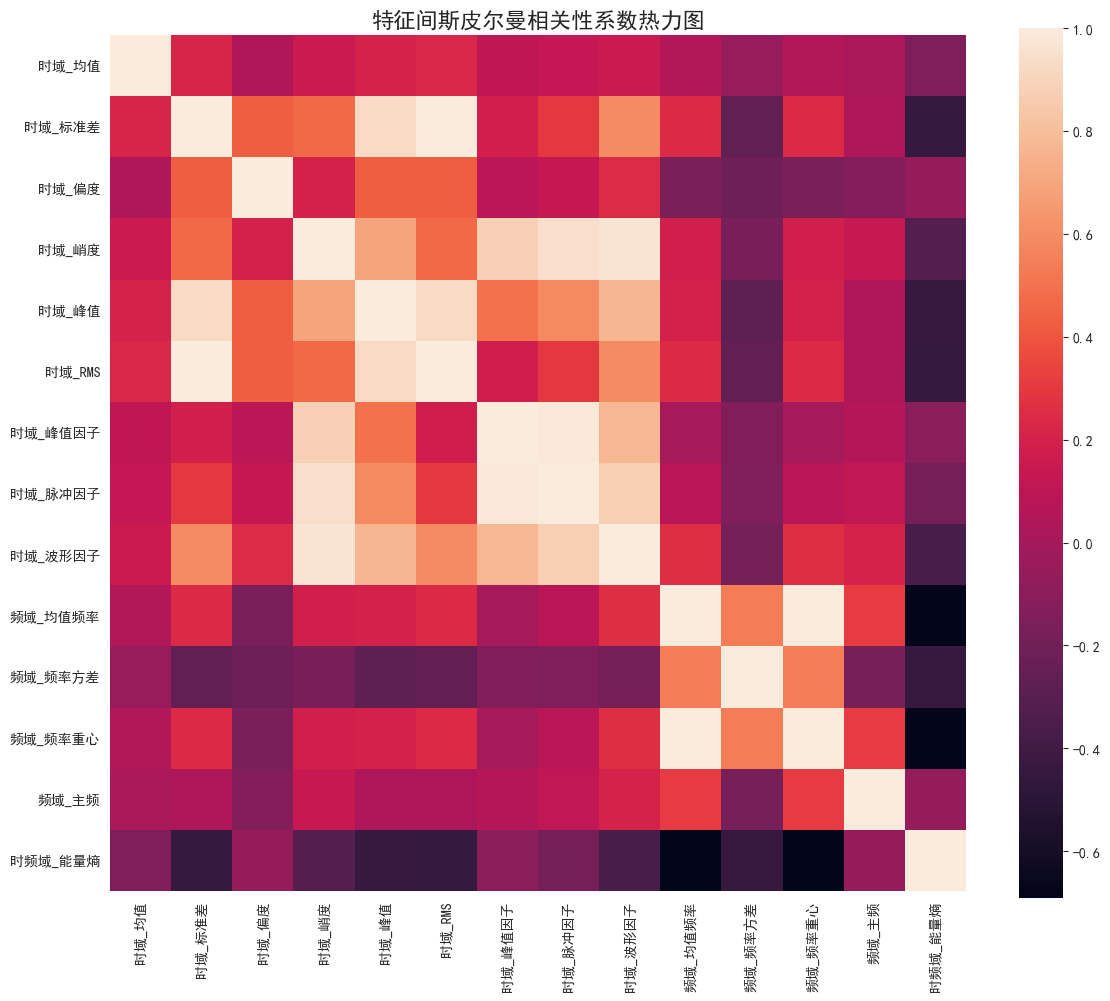

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取特征文件
df = pd.read_csv(r"all_features.csv")

# 去掉非数值列（比如文件名、数据集标签）
numeric_df = df.select_dtypes(include=['float64','int64'])

# 计算斯皮尔曼相关性
corr = numeric_df.corr(method='spearman')

# 绘制热力图
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cbar=True, square=True,
            xticklabels=True, yticklabels=True)

plt.title("特征间斯皮尔曼相关性系数热力图", fontsize=16)
plt.tight_layout()
plt.show()

In [20]:
import pandas as pd

# 读取特征文件
df = pd.read_csv(r"all_features.csv")

# 去掉非数值列
meta_cols = ["数据集", "文件名", "文件夹"]  # 非数值型的列
numeric_df = df.drop(columns=[col for col in meta_cols if col in df.columns])

# 计算斯皮尔曼相关性
corr = numeric_df.corr(method="spearman").abs()

# 设置阈值（比如 0.9 以上算强相关）
threshold = 0.9
upper = corr.where(~np.tril(np.ones(corr.shape)).astype(bool))

# 找到要删除的特征
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print(f"强相关（>{threshold}）特征个数: {len(to_drop)}")
print("将删除这些特征:", to_drop)

# 生成筛选后的表
filtered_df = df.drop(columns=to_drop)

# 保存输出
save_path = r"all_features_selected.csv"
filtered_df.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"✅ 筛选后的特征表已保存: {save_path}")

强相关（>0.9）特征个数: 5
将删除这些特征: ['时域_峰值', '时域_RMS', '时域_脉冲因子', '时域_波形因子', '频域_频率重心']
✅ 筛选后的特征表已保存: all_features_selected.csv


In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# 读取特征表（用你筛选后的文件更合适）
df = pd.read_csv(r"all_features.csv")

# 标签列，这里假设用“数据集”或者“文件夹”作为类别标签
# 你可以根据实际需求换成 "Category" 或者 "故障类型"
target_col = "文件夹" if "文件夹" in df.columns else "数据集"

# 分离特征和标签
X = df.drop(columns=["数据集","文件名","文件夹"], errors="ignore")
y = df[target_col]

# 标签编码
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 随机森林训练
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X, y_encoded)

# 获取特征重要性
importances = model.feature_importances_
importance_df = pd.DataFrame({
    "特征": X.columns,
    "重要性": importances
}).sort_values(by="重要性", ascending=False)

# 保存结果
save_path = r"feature_importance.csv"
importance_df.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"✅ 特征重要性已保存: {save_path}")
print(importance_df.head(10))  # 打印前10个最重要的特征

✅ 特征重要性已保存: feature_importance.csv
         特征       重要性
1    时域_标准差  0.100920
5    时域_RMS  0.098249
4     时域_峰值  0.091922
6   时域_峰值因子  0.086610
9   频域_均值频率  0.083384
11  频域_频率重心  0.083049
7   时域_脉冲因子  0.076672
8   时域_波形因子  0.068551
3     时域_峭度  0.064638
10  频域_频率方差  0.062170


In [22]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 读取特征表
df = pd.read_csv(r"all_features.csv")

# 定义映射规则（更细化）
def extract_fault_type(row):
    folder = str(row.get("文件夹", "")) + str(row.get("文件名", ""))

    if "B" in folder and "Normal" not in folder:  # 避免误判 Normal
        return "滚动体故障"
    elif "IR" in folder:
        return "内圈故障"
    elif "OR" in folder:
        return "外圈故障"
    elif "Normal" in folder:
        return "正常"
    else:
        return "未知"

# 新增故障类型列
df["故障类型"] = df.apply(extract_fault_type, axis=1)

# 编码
le = LabelEncoder()
df["故障类型编码"] = le.fit_transform(df["故障类型"])

print("标签映射：", dict(zip(le.classes_, le.transform(le.classes_))))

# 保存新文件
save_path = r"all_features_with_labels.csv"
df.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"✅ 已保存: {save_path}")

标签映射： {'内圈故障': np.int64(0), '外圈故障': np.int64(1), '正常': np.int64(2), '滚动体故障': np.int64(3)}
✅ 已保存: all_features_with_labels.csv


In [23]:
import pandas as pd

# 读取特征表
df = pd.read_csv(r"all_features_with_labels.csv")

# 删除不需要的列
drop_cols = ["数据集", "文件名", "文件夹", "故障类型"]
df_clean = df.drop(columns=[col for col in drop_cols if col in df.columns])

# 保存新的文件
save_path = r"all_features_clean.csv"
df_clean.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"✅ 已保存: {save_path}")
print("新表格列名：", df_clean.columns.tolist())

✅ 已保存: all_features_clean.csv
新表格列名： ['时域_均值', '时域_标准差', '时域_偏度', '时域_峭度', '时域_峰值', '时域_RMS', '时域_峰值因子', '时域_脉冲因子', '时域_波形因子', '频域_均值频率', '频域_频率方差', '频域_频率重心', '频域_主频', '时频域_能量熵', '故障类型编码']
